We are going to analyze the credit data from LendingClub, which includes both accepted and rejected loan applications. 
The primary goal is to perform a deep Exploratory Data Analysis (EDA) on variables such as Risk Scores, Debt-to-Income (DTI) ratios, and employment history.

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_rej = pd.read_csv("processed_data/rejected_data.csv")
df_acc = pd.read_csv("processed_data/accepted_data.csv")

To understand the separation between both groups, we plot the distribution of Risk Scores. This helps identify the specific thresholds where the bank transitions from rejecting to accepting applications.

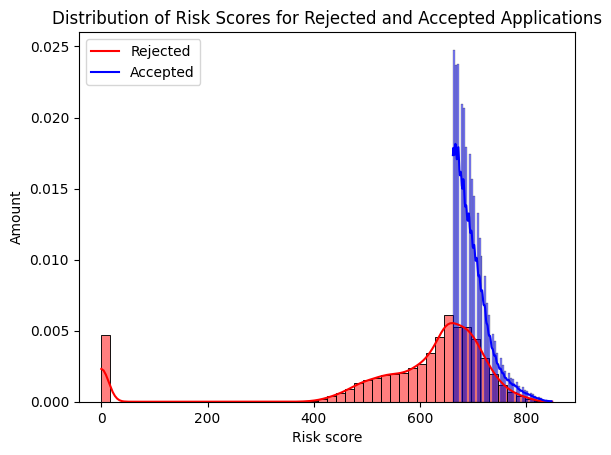

In [103]:
sns.histplot(df_rej["Risk_Score"], color = "red", bins=50, kde=True, stat="density", common_norm=False)
sns.histplot(df_acc["risk_score"], color = "blue", bins=50, kde=True, stat="density", common_norm=False)
plt.xlabel("Risk score")
plt.ylabel("Amount")
plt.legend(["Rejected", "Accepted"])
plt.title("Distribution of Risk Scores for Rejected and Accepted Applications")
plt.show()

The distribution plot reveals a clear decision boundary around a Risk Score of 660. Below this threshold, the volume of accepted applications (blue) drops to near zero, while rejected applications (red) dominate the lower spectrum. This indicates that a score above 650 is a non-negotiable requirement for the lender's approval process.

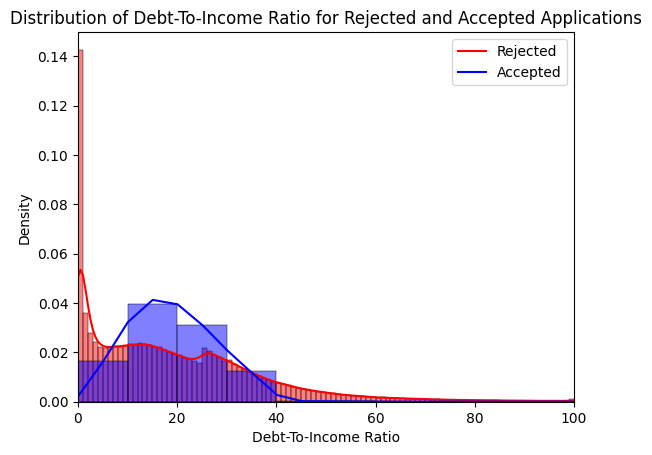

In [104]:
df_rej["Debt-To-Income Ratio"] = pd.to_numeric(df_rej["Debt-To-Income Ratio"].astype(str).str.replace('%', ''), errors='coerce')
df_acc["dti"] = pd.to_numeric(df_acc["dti"], errors='coerce')

sns.histplot(df_rej[df_rej["Debt-To-Income Ratio"].between(0, 100)]["Debt-To-Income Ratio"], color = "red", 
             bins=100, kde=True, stat = "density", common_norm=False)
sns.histplot(df_acc["dti"], color = "blue", bins=100, kde=True, stat = "density", common_norm=False)
plt.legend(["Rejected", "Accepted"])
plt.title("Distribution of Debt-To-Income Ratio for Rejected and Accepted Applications")
plt.xlabel("Debt-To-Income Ratio")
plt.ylabel("Density")
plt.xlim(0, 100)
plt.show()

Most accepted loans fall between 10% and 30% DTI, showing the bank prefers clients who keep at least two-thirds of their income debt-free.
Beyond 40% DTI, approvals drop to nearly zero. This confirms that high debt levels act as an absolute blocker for loan acceptance.

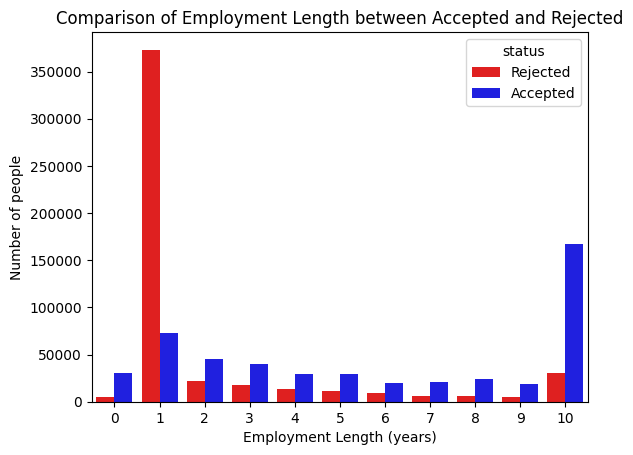

In [105]:
def clean_emp_length(df, col_name):
    extracted = df[col_name].astype(str).str.extract(r'(\d+)')[0]
    df[col_name] = extracted.fillna(0).astype(int)
    return df

df_acc = clean_emp_length(df_acc, 'emp_length')
if 'Employment Length' in df_rej.columns:
    df_rej = clean_emp_length(df_rej, 'Employment Length')
    df_rej.rename(columns={'Employment Length': 'emp_length'}, inplace=True)
else:
    df_rej = clean_emp_length(df_rej, 'emp_length')

df_rej['status'] = "Rejected"
df_acc['status'] = "Accepted"

df_emp = pd.concat([df_rej[['emp_length', 'status']], df_acc[['emp_length', 'status']]])

sns.countplot(x='emp_length', hue='status', data=df_emp, palette=['red', 'blue'])
plt.xlabel("Employment Length (years)")
plt.ylabel("Number of people")
plt.title("Comparison of Employment Length between Accepted and Rejected")
plt.show()

Applicants with 10+ years of employment show the highest approval volume, marking a major threshold for lender trust.
A massive rejection peak at 1 year suggests that early-career instability is a primary screening filter.
While job seniority helps, it acts more as a "bonus" compared to the harder filters of Risk Score and DTI.

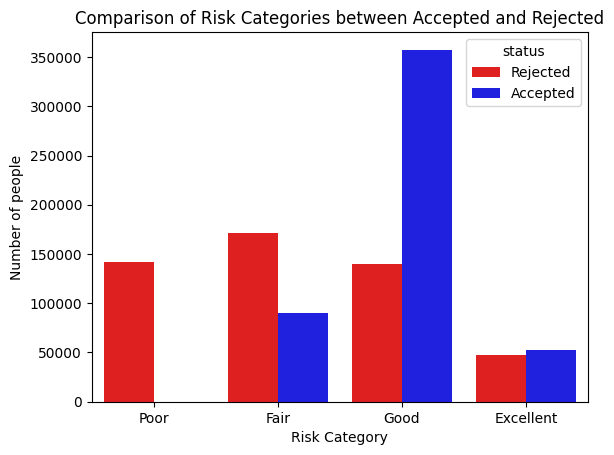

In [106]:
def categorize_risk(score):
    if score < 580: return 'Poor'
    if score < 670 and score >= 580: return 'Fair'
    if score < 740 and score >= 670: return 'Good'
    return 'Excellent'

df_rej['Risk_Category'] = df_rej['Risk_Score'].apply(categorize_risk)
df_acc['Risk_Category'] = df_acc['risk_score'].apply(categorize_risk)

order = ['Poor', 'Fair', 'Good', 'Excellent']

sns.countplot(x='Risk_Category', hue='status', data=pd.concat([df_rej, df_acc]), order = order, palette=['red', 'blue'])
plt.xlabel("Risk Category")
plt.ylabel("Number of people")
plt.title("Comparison of Risk Categories between Accepted and Rejected")
plt.show()

We categorized clients into 4 credit tiers based on the FICO standard: poor, fair, good and excellent. The visualization shows that "poor" and "fair" have a higher rejection percentage, while "good" tier is the primary decision zon for aprovals. This segmentation confirms that while a high credit tier is a prerequisite for approval, additional factors like DTI and employment stability become decisive filters for applicants in the middle-to-high scoring brackets.

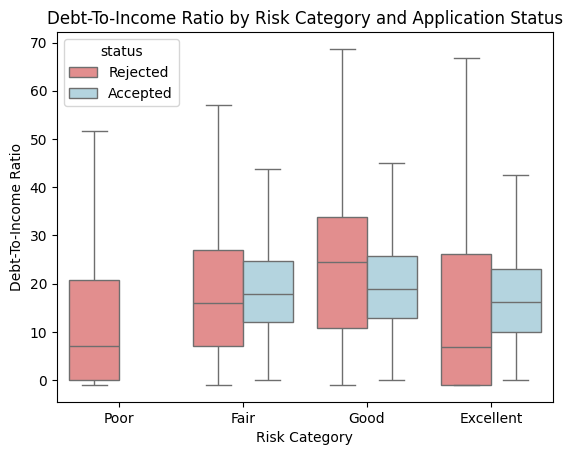

In [107]:
df_comb = pd.concat(
    [df_rej[['Risk_Category', 'Debt-To-Income Ratio', 'status']].rename(columns={'Debt-To-Income Ratio': 'dti'}), 
    df_acc[['Risk_Category', 'dti', 'status']]])

sns.boxplot(data=df_comb[df_comb['dti'] <= 100], x='Risk_Category', y='dti', hue='status', 
            palette=['lightcoral', 'lightblue'], order = order, showfliers=False) 
plt.xlabel("Risk Category")
plt.ylabel("Debt-To-Income Ratio")
plt.title("Debt-To-Income Ratio by Risk Category and Application Status")
plt.show()

This visualization compares the DTI ratios across different credit categories for both accepted and rejected applications. The data reveals a clear "solvency gap": in every risk category, accepted applicants (blue) maintain significantly lower and more stable DTI levels compared to those rejected (red). Even in the Excellent tier, a high DTI remains a common cause for rejection, proving that financial capacity is just as critical as credit history in the final lending decision.

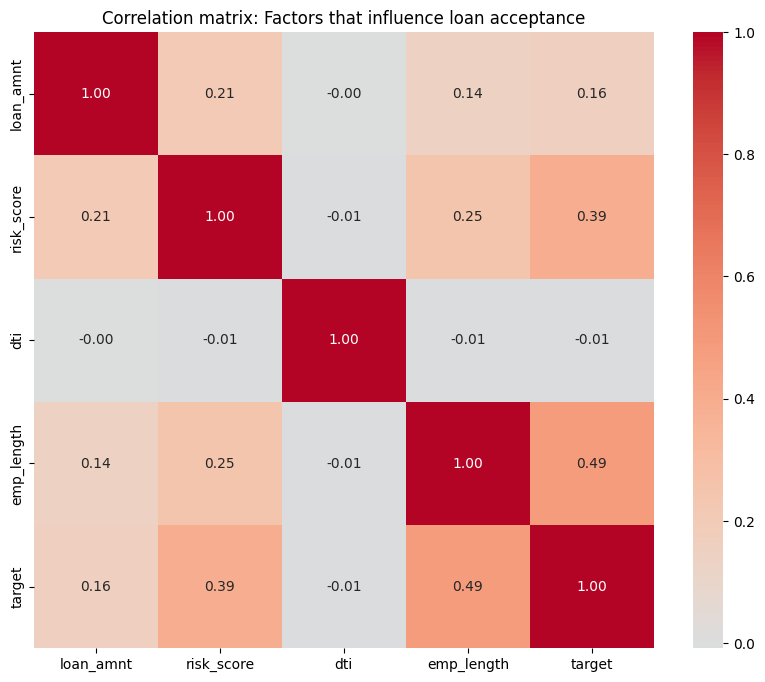

In [108]:
df_rej_num = df_rej[['Amount Requested', 'Risk_Score', 'Debt-To-Income Ratio', 'emp_length']].copy()
df_acc_num = df_acc[['loan_amnt', 'risk_score', 'dti', 'emp_length']].copy()

df_rej_num.columns = ['loan_amnt', 'risk_score', 'dti', 'emp_length']
df_rej_num['dti'] = pd.to_numeric(df_rej_num['dti'].astype(str).str.replace('%', ''), errors='coerce')

df_rej_num['target'] = 0
df_acc_num['target'] = 1

df_unified = pd.concat([df_rej_num, df_acc_num], ignore_index=True)
df_unified.to_csv("processed_data/unified_data_to_ML.csv", index=False)

df_corr = pd.concat([df_rej_num, df_acc_num]).dropna().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('Correlation matrix: Factors that influence loan acceptance')
plt.show()

This step standardizes and merges both datasets into a unified structure, cleaning the DTI field and defining a binary target for machine learning. The resulting correlation matrix confirms the high impact of Risk Scores on loan approval, ensuring the final dataset is properly formatted and strategically validated for predictive modeling.